In [98]:
reset -fs

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [114]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

def difference(old_values, d):
    new_values = list()
    for i in range(d, len(old_values)):
        value = old_values[i] - old_values[i - d]
        new_values.append(value)
    return new_values

In [101]:
zillow = pd.read_csv('zillow-carlifornia .csv', parse_dates=True,squeeze=True)

In [102]:
zillow.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate,MedianRentalPrice_AllHomes.California
0,2004-01-31,326752.55,5.02,7.9,NaN
1,2004-02-29,329501.50,4.94,7.8,NaN
2,2004-03-31,340125.45,4.74,7.8,NaN
3,2004-04-30,355329.50,5.16,7.5,NaN
4,2004-05-31,367818.15,5.64,7.3,NaN


In [103]:
zillow.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"}, inplace=True)
zillow.Date = pd.to_datetime(zillow.Date)

In [104]:
zillow.head()

,Date,MedianSoldPrice,MedianMortageRate,UnemploymentRate,MedianRentalPrice_AllHomes.California
0,2004-01-31,326752.55,5.02,7.9,NaN
1,2004-02-29,329501.50,4.94,7.8,NaN
2,2004-03-31,340125.45,4.74,7.8,NaN
3,2004-04-30,355329.50,5.16,7.5,NaN
4,2004-05-31,367818.15,5.64,7.3,NaN


In [106]:
data  = zillow.loc[zillow['Date']<'2016-01-01']
test = zillow.loc[zillow['Date']>'2016-01-01']

## Initial Look at Data

In [107]:
median_sold = data['MedianSoldPrice']

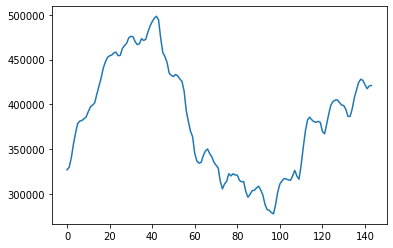

In [108]:
plt.plot(median_sold)

## Difference Data

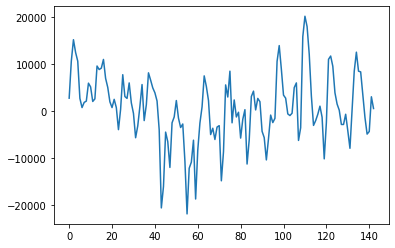

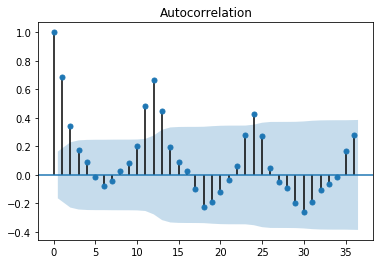

Results of Dickey-Fuller Test:
Test Statistic                  -1.687305
p-value                          0.437665
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [115]:
# d = 1
d1 = difference(median_sold, d=1)
plt.plot(d1) 
plot_acf(d1,lags=36) 
plt.show()
adf_test(d1)

Need to do another differencing.

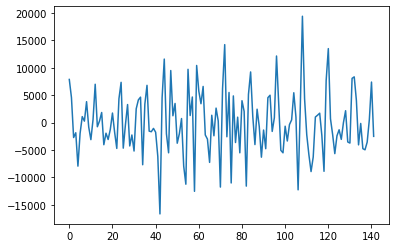

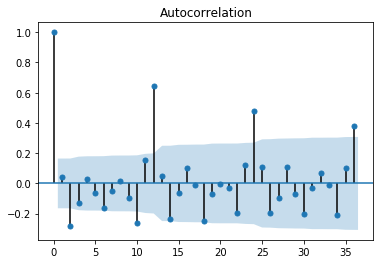

Results of Dickey-Fuller Test:
Test Statistic                  -4.918846
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [116]:
d2 = difference(d1, d=1)
plt.plot(d2) 
plot_acf(d2,lags=36) 
plt.show()
adf_test(d2)

Removed trend. Need to remove seasonality. ACF tells us lag = 12.

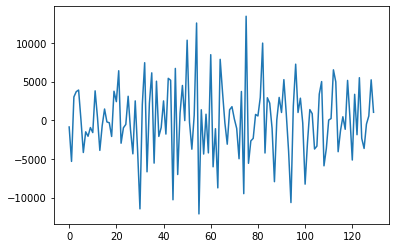

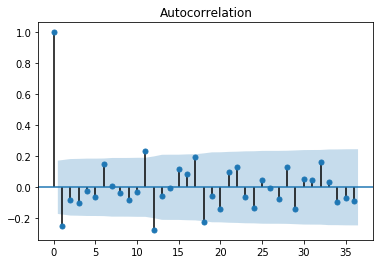

Results of Dickey-Fuller Test:
Test Statistic                  -5.149454
p-value                          0.000011
#Lags Used                      13.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


In [117]:
d3 = difference(d2, d=12)

plt.plot(d3)
plot_acf(d3,lags=36) 
plt.show()
adf_test(d3)

Seasonality is now removed. After one time differencing.

# Split Data

In [125]:
# Train/Test Split for Median Sold
train_size = int(len(median_sold) * 0.75)
train, test = median_sold[:train_size], median_sold[train_size:]

In [126]:
# Train/Test Split for Exogeneous Variables: Median Mortgage, Unemployment Rate
X = data[['MedianMortageRate','UnemploymentRate']]
exog_train, exog_test = X[:train_size], X[train_size:]

In [131]:
# plt.plot(train)
# plt.plot(test)

# SARIMAX

Find orders for SARIMAX, using Univariate Median Sold Price.

In [132]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=2, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1871.765, BIC=1884.482, Fit time=0.533 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=1867.270, BIC=1872.356, Fit time=0.015 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=1871.057, BIC=1881.231, Fit time=0.104 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=1871.296, BIC=1881.469, Fit time=0.189 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=1869.071, BIC=1876.701, Fit time=0.065 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=1869.070, BIC=1876.700, Fit time=0.095 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(1, 1, 1, 12); AIC=1871.118, BIC=1881.291, Fit time=0.103 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=1869.284, BIC=1876.914, Fit time=0.062 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=1869.529, BIC=1877.159, Fit time=0.041 seconds
Fit ARIMA: order=(1, 2, 1) s

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [136]:
# SARIMAX(1, 2, 1)x(0, 1, 0, 12)

In [137]:
# Assumes one way direction Unemployment predict -> only Bankcrupcy
modelx = SARIMAX(train, order=(1,2,1),exog=exog_train)
fitx=modelx.fit()
print(fitx.summary())

                           Statespace Model Results                           
Dep. Variable:        MedianSoldPrice   No. Observations:                  108
Model:               SARIMAX(1, 2, 1)   Log Likelihood               -1059.459
Date:                Sat, 07 Dec 2019   AIC                           2128.919
Time:                        22:42:31   BIC                           2142.236
Sample:                             0   HQIC                          2134.316
                                - 108                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
MedianMortageRate  4122.7149   2507.259      1.644      0.100    -791.422    9036.851
UnemploymentRate   -339.5362    628.343     -0.540      0.589   -1571.065     891.993
ar.L1                 0.

In [141]:
fc = fitx.predict(start=108, end=143, exog=exog_test)

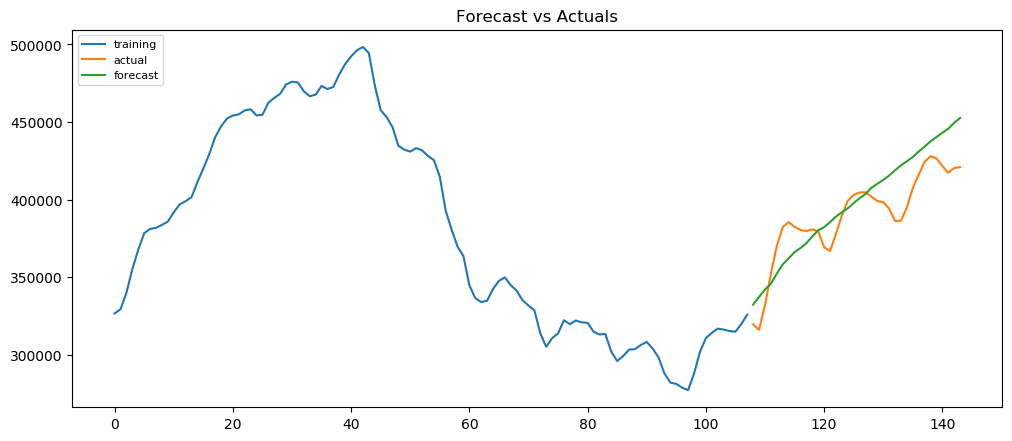

In [142]:
fc_series = pd.Series(fc)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## RMSE - SARIMAX

In [144]:
mse = ((fc_series - test) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)

17892.508644434107


# VAR 1

In [150]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [148]:
# Train/Test Split for Exogeneous Variables: Median Mortgage, Unemployment Rate
X = data[['MedianSoldPrice','MedianMortageRate','UnemploymentRate']]
exog_train, exog_test = X[:train_size], X[train_size:]

In [152]:
# Fitting an AR(1) process
var_model1 = VAR(endog=exog_train)
var_model1_fit = var_model1.fit(1)
print(var_model1_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 07, Dec, 2019
Time:                     22:58:51
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    13.1529
Nobs:                     107.000    HQIC:                   12.9746
Log likelihood:          -1131.12    FPE:                    382013.
AIC:                      12.8531    Det(Omega_mle):         342185.
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                   -26234.737319     11412.464591           -2.299           0.022
L1.MedianSoldPrice           1.052738         0.026017           40.463           0.000
L1.MedianMortageRate  

In [202]:
# Predicting the MedianSoldPrice of the test sample.
fc = var_model1_fit.forecast(var_model1_fit.y, steps=len(exog_test))
cols = exog_test.columns
pred = pd.DataFrame(index=exog_test.index,columns=[cols])

for j in range(0,3):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]

/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [203]:
pred.columns = exog_test.columns

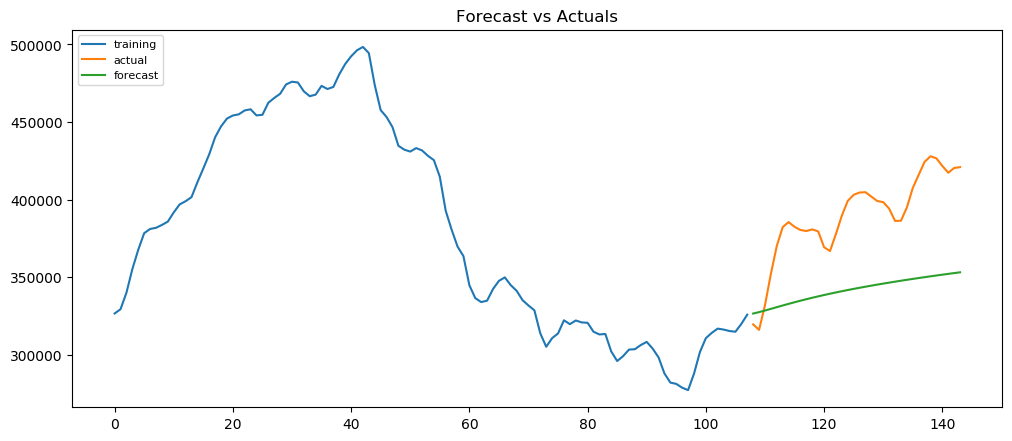

In [204]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(exog_train.MedianSoldPrice, label='training')
plt.plot(exog_test.MedianSoldPrice, label='actual')
plt.plot(pred.MedianSoldPrice, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## RMSE - VAR AR(1)

In [205]:
mse = ((pred['MedianSoldPrice'] - exog_test['MedianSoldPrice']) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)

51980.4469305533


# VAR 2

In [201]:
# Fitting an AR(1) process
var_model2 = VAR(endog=exog_train)
var_model2_fit = var_model2.fit(2)
print(var_model2_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 07, Dec, 2019
Time:                     23:23:12
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    12.9060
Nobs:                     106.000    HQIC:                   12.5922
Log likelihood:          -1086.28    FPE:                    237744.
AIC:                      12.3784    Det(Omega_mle):         196242.
--------------------------------------------------------------------
Results for equation MedianSoldPrice
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                    -8712.160935      9795.139153           -0.889           0.374
L1.MedianSoldPrice           1.633847         0.077860           20.984           0.000
L1.MedianMortageRate  

In [206]:
# Predicting the MedianSoldPrice of the test sample.
fc2 = var_model2_fit.forecast(var_model2_fit.y, steps=len(exog_test))
cols = exog_test.columns
pred2 = pd.DataFrame(index=exog_test.index,columns=[cols])

for j in range(0,3):
    for i in range(0, len(fc2)):
        pred2.iloc[i][j] = fc2[i][j]

In [209]:
pred2.columns = exog_test.columns

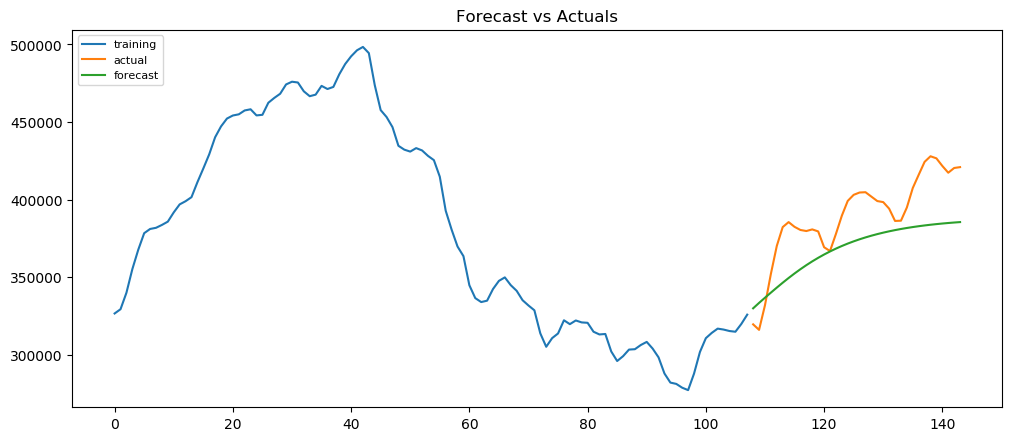

In [210]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(exog_train.MedianSoldPrice, label='training')
plt.plot(exog_test.MedianSoldPrice, label='actual')
plt.plot(pred2.MedianSoldPrice, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## RMSE VAR AR(2)

In [211]:
mse = ((pred2['MedianSoldPrice'] - exog_test['MedianSoldPrice']) ** 2).mean()
rmse=np.sqrt(mse)
print(rmse)

26080.438494767863
